In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import cv2
import random
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout,GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.utils import to_categorical

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


<h1> Defining Path Variables, Reading Data </h1>

In [3]:
parent_path= os.path.abspath(os.pardir) #path of parent directory

In [4]:
print(parent_path)

C:\Users\Shashank Uttrani\Desktop\mahavir\distracted_driver


In [5]:
data_path=os.path.join(parent_path,"data") #path of the data directory

In [6]:
print(data_path)

C:\Users\Shashank Uttrani\Desktop\mahavir\distracted_driver\data


In [7]:
image_path=os.path.join(data_path,"train") #path of the train images

In [8]:
print(image_path)

C:\Users\Shashank Uttrani\Desktop\mahavir\distracted_driver\data\train


In [9]:
test_image_path=os.path.join(data_path,"test") #path of the train images

In [10]:
test_image_path

'C:\\Users\\Shashank Uttrani\\Desktop\\mahavir\\distracted_driver\\data\\test'

In [11]:
data_info=pd.read_csv(os.path.join(data_path,"driver_imgs_list.csv")) #image-class information

In [13]:
data_info.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [14]:
data_info["classname"]=data_info["classname"].apply(lambda x: int(x[1])) #converting class name from str to int

In [15]:
data_info.head()

subject  classname            img
0    p002          0  img_44733.jpg
1    p002          0  img_72999.jpg
2    p002          0  img_25094.jpg
3    p002          0  img_69092.jpg
4    p002          0  img_92629.jpg

<h1> Basic EDA </h1>

In [16]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  int64 
 2   img        22424 non-null  object
dtypes: int64(1), object(2)
memory usage: 525.7+ KB


In [17]:
data_info['classname'].value_counts() #instances of each class

0    2489
3    2346
4    2326
6    2325
2    2317
5    2312
1    2267
9    2129
7    2002
8    1911
Name: classname, dtype: int64

In [18]:
data_info["subject"].value_counts()

p021    1237
p022    1233
p024    1226
p026    1196
p016    1078
p066    1034
p049    1011
p051     920
p014     876
p015     875
p035     848
p047     835
p012     823
p081     823
p064     820
p075     814
p061     809
p056     794
p050     790
p052     740
p002     725
p045     724
p039     651
p041     605
p042     591
p072     346
Name: subject, dtype: int64

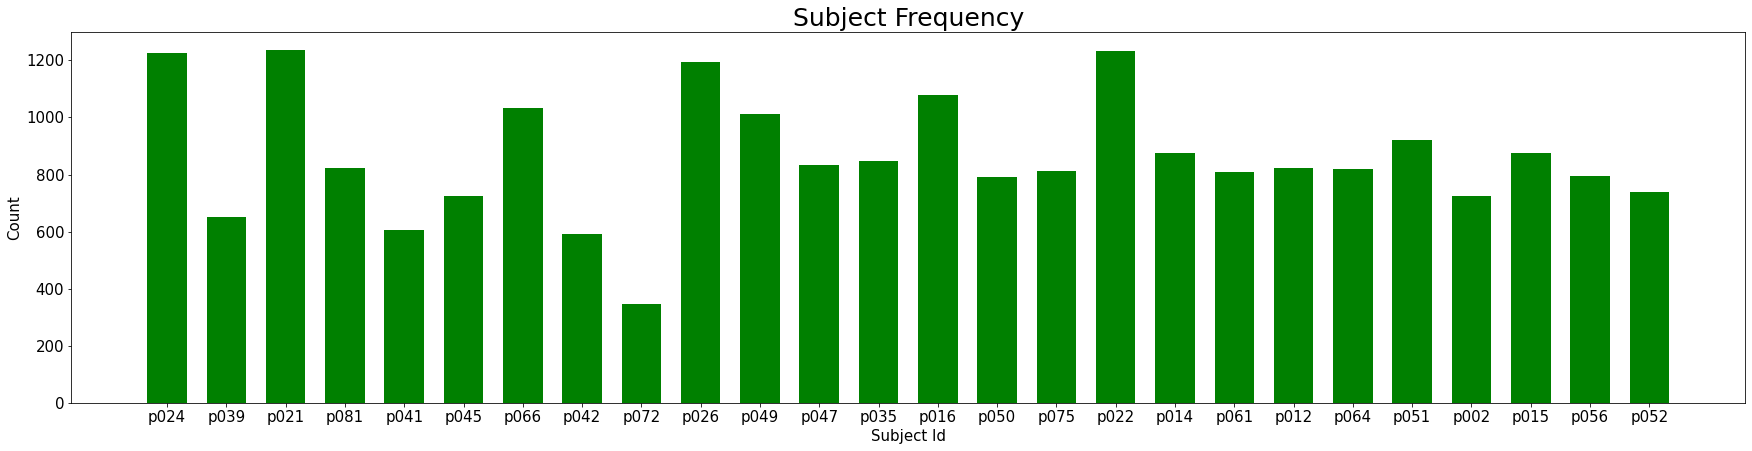

In [19]:
nf = data_info['subject'].value_counts(sort=False)
labels = data_info['subject'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(30,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="g")

plt.title('Subject Frequency',size=25)
plt.xlabel('Subject Id',size=15)
plt.ylabel('Count',size=15)

plt.show()

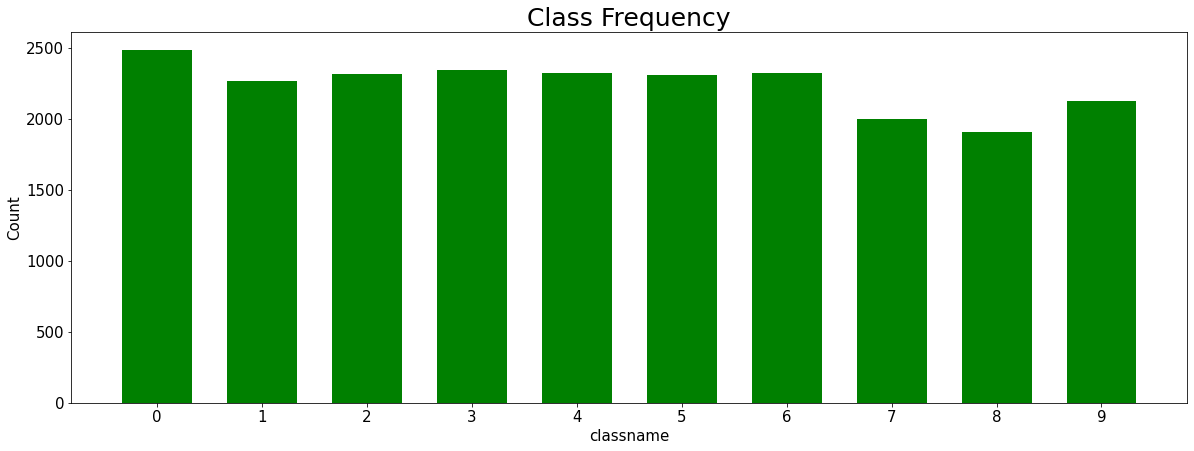

In [20]:
nf = data_info['classname'].value_counts(sort=False)
labels = data_info['classname'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="g")

plt.title('Class Frequency',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [21]:
#dict mapping class index to class name

#due to flipping of images perception of left and right changes
#so we have to interchange the following classes
#interchange c2 (talking on the phone - right) and c4 (talking on the phone - left)
#interchange c1 (texting - right) and c3 (texting - left)

#check image 14 (c4-talking left in original) -talking right after flipping
#check image 26100 (c1-texting right in original) -texting left after flipping

class_name={0: "safe driving", 1: "texting - left", 2: "talking on the phone - left", 3: "texting - right",
    4: "talking on the phone - right", 5: "operating the radio", 6: "drinking" , 7: "reaching behind",
    8: "hair and makeup", 9: "talking to passenger"}

<h1> Data Preprocessing </h1>

<h2> 1) Image Resizing </h2> 

image shape:  (480, 640, 3)
height  of an image in pixels:  480
width  of an image in pixels:  640
number of channels of an image:  3


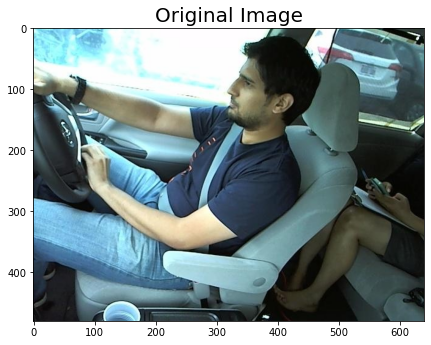

In [22]:
#mobilenet input takes image of size 224x224
im_size=224 #defining the target input size

folder_path=os.path.join(image_path,"c0") #path of the train images
image_name= random.choice(os.listdir(folder_path)) #selects one image from all images in c0

image = cv2.imread(os.path.join(image_path,"img_0.jpg"))
img_path=os.path.join(folder_path,image_name)
image=cv2.imread(img_path)
resize_image=cv2.resize(image, dsize=(im_size, im_size)) #1st arg=new width,2nd arg=new height

#understanding the shape of the image
print("image shape: ",image.shape)
height, width, channels=image.shape
print("height  of an image in pixels: ",height)
print("width  of an image in pixels: ",width)
print("number of channels of an image: ",channels)

#plotting the original image 
#and resized image
fig=plt.subplots(1,1,figsize=(7,7))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image",fontsize=20)
#ax[1].imshow(cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB))
#ax[1].set_title("Resized Image",fontsize=20)
plt.show()

image shape:  (224, 224, 3)
height  of an image in pixels:  224
width  of an image in pixels:  224
number of channels of an image:  3


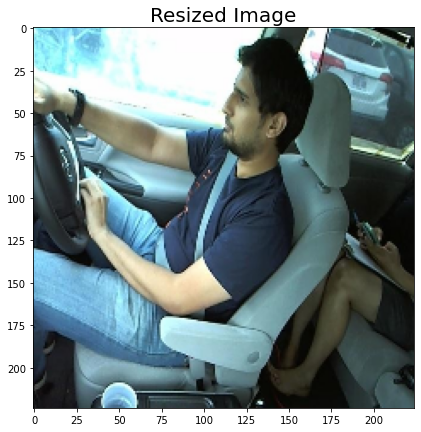

In [23]:
resize_image=cv2.resize(image, dsize=(im_size, im_size)) #1st arg=new width,2nd arg=new height

#understanding the shape of the image
print("image shape: ",resize_image.shape)
height, width, channels=resize_image.shape
print("height  of an image in pixels: ",height)
print("width  of an image in pixels: ",width)
print("number of channels of an image: ",channels)

fig=plt.subplots(1,1,figsize=(7,7))
plt.imshow(cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB))
plt.title("Resized Image",fontsize=20)
plt.show()

<h2> 2) Image Augmentation </h2> 

In [24]:
#augmentation to reduce overfitting as there is limited data
#augmentation would send slighlty modified images each time- so the same images won't be fed to the neural network

img_gen = ImageDataGenerator()

<h3> 1. Rotation </h3>

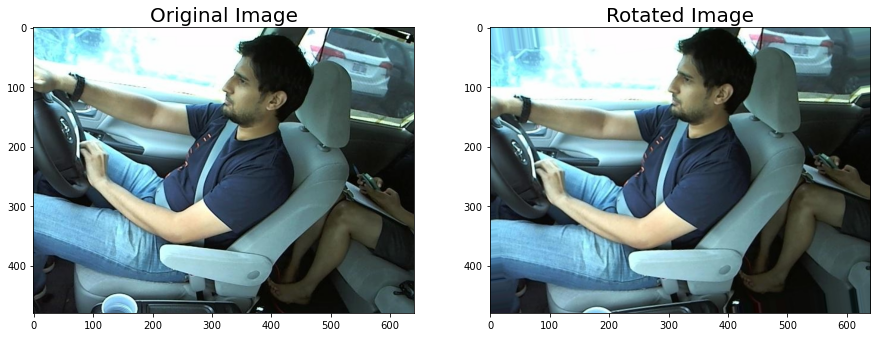

In [25]:
fig, ax= plt.subplots(1, 2, figsize = (15,15))

#random rotation between -30 and 30 degree
aug=img_gen.apply_transform(x=image,transform_parameters={"theta":np.random.randint(-30,30)})

ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image",fontsize=20)
ax[1].imshow(cv2.cvtColor(aug, cv2.COLOR_BGR2RGB))
ax[1].set_title("Rotated Image",fontsize=20)
plt.show()

<h3> 2. Shift </h3>

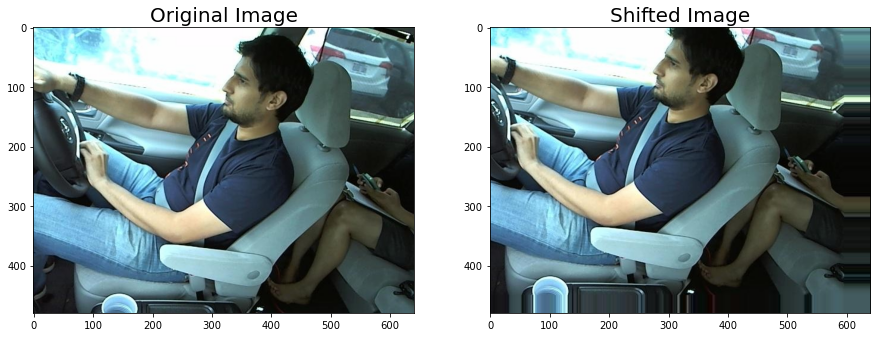

In [26]:
fig, ax= plt.subplots(1, 2, figsize = (15,15 ))

#random shift between -50 and 50 pixels
aug=img_gen.apply_transform(x=image,transform_parameters={"tx":np.random.randint(-50,50),"ty":np.random.randint(-50,50)})

ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image",fontsize=20)
ax[1].imshow(cv2.cvtColor(aug, cv2.COLOR_BGR2RGB))
ax[1].set_title("Shifted Image",fontsize=20)
plt.show()

<h3> 3. Shear </h3>

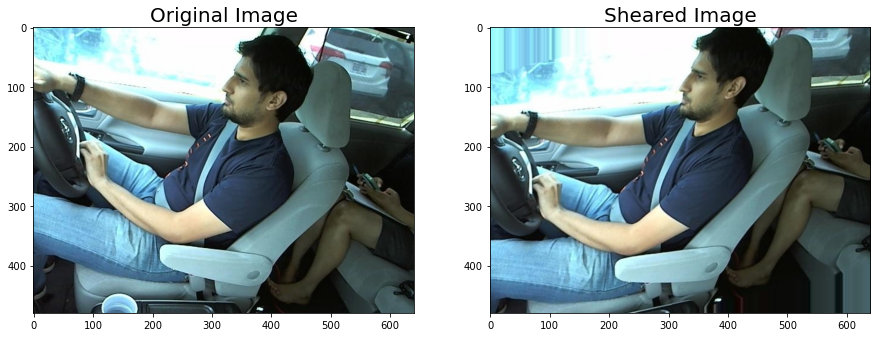

In [27]:
fig, ax= plt.subplots(1, 2, figsize = (15,15 ))

#shears image
aug=img_gen.apply_transform(x=image,transform_parameters={"shear":np.random.randint(-30,30)})
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image",fontsize=20)
ax[1].imshow(cv2.cvtColor(aug, cv2.COLOR_BGR2RGB))
ax[1].set_title("Sheared Image",fontsize=20)
plt.show()

<h3> 4. Zoom </h3>

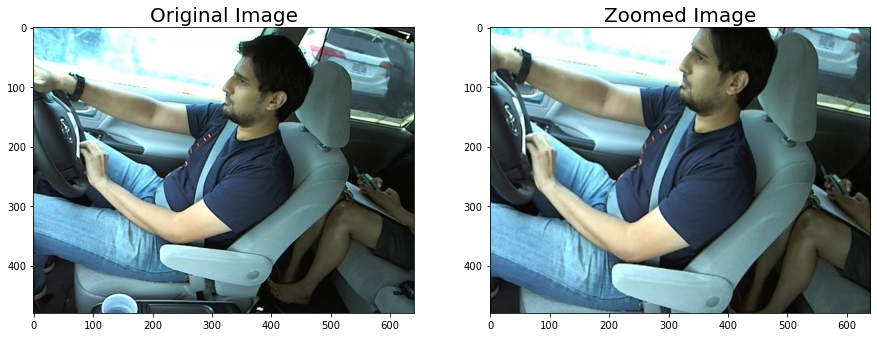

In [28]:
fig, ax= plt.subplots(1, 2, figsize = (15,15 ))

#zooms randomly between 0.5 and 1.5 times both in x and y direction
aug=img_gen.apply_transform(x=image,transform_parameters={"zx":np.random.uniform(0.5,1.5),"zy":np.random.uniform(0.5,1.5)})
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image",fontsize=20)
ax[1].imshow(cv2.cvtColor(aug, cv2.COLOR_BGR2RGB))
ax[1].set_title("Zoomed Image",fontsize=20)
plt.show()

<h3> 5. Total Augmentation </h3>

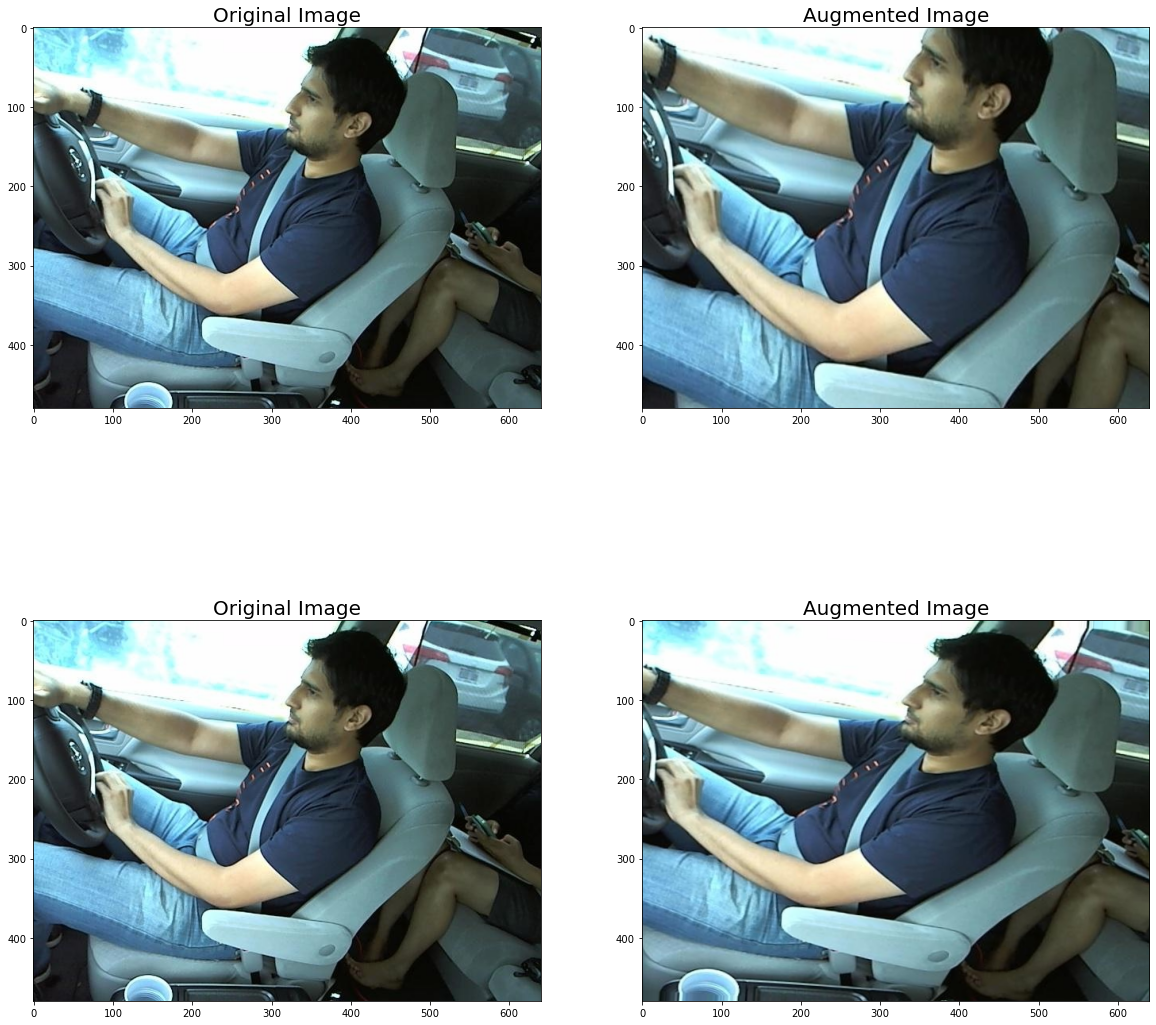

In [29]:
fig, ax= plt.subplots(2, 2, figsize = (20,20))

#image augmentation
for i in range(2):
    aug=img_gen.apply_transform(x=image,transform_parameters={"theta":np.random.randint(-20,20),
                                                              "tx":np.random.randint(-20,20),
                                                              "ty":np.random.randint(-20,20),
                                                              "shear":np.random.randint(-20,20),
                                                              "zx":np.random.uniform(0.7,1.2),
                                                              "zy":np.random.uniform(0.7,1.2)})
    ax[i][0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i][0].set_title("Original Image",fontsize=20)
    ax[i][1].imshow(cv2.cvtColor(aug, cv2.COLOR_BGR2RGB))
    ax[i][1].set_title("Augmented Image",fontsize=20)


<h1> Image Data Reading </h1>

In [30]:
#to avoid data leakage, the split has been done on the participants id
#if the same pose for the same person occurs in both train, test, validation- data leakage
#split on the basis of participant ids- val and test would have different people which haven't been seen before in train

train_subject=["p021","p022","p024","p026","p016","p066","p049","p051","p014","p015","p035","p047",
              "p081","p012","p064","p050","p039","p042","p072","p052"]
val_subject=["p075","p061","p056","p041","p002","p045"]

In [32]:
#reading test images
test_image1=[] #mobilenet, resnet, vgg16-(224,224)
test_image2=[] #xception-(299,299)

for label in range(10): #each distraction has a separate folder
    print("in folder C",label) #to track the current folder number
    folder_path=os.path.join(image_path,"c"+str(label)) #path of the train images
    image_names= os.listdir(folder_path) #all image names in a folder
    for image_name in tqdm(image_names):
        driver = data_info[data_info['img'] == image_name]['subject'].values[0]
        if driver in val_subject:
            img_path=os.path.join(folder_path,image_name)
            image=cv2.imread(img_path)
            image1= cv2.resize(image, dsize=(224, 224)) #1st arg=new width,2nd arg=new height-mobilenet,resnet,vgg16
            test_image1.append([image1,label])
            image2= cv2.resize(image, dsize=(299, 299)) #1st arg=new width,2nd arg=new height-xception
            test_image2.append([image2,label])

  2%|█▌                                                                             | 50/2489 [00:00<00:05, 485.00it/s]

in folder C 0


  2%|█▍                                                                             | 42/2267 [00:00<00:05, 419.62it/s]

in folder C 1


  2%|█▎                                                                             | 39/2317 [00:00<00:06, 374.66it/s]

in folder C 2


  2%|█▍                                                                             | 41/2346 [00:00<00:05, 393.88it/s]

in folder C 3


  3%|██▋                                                                            | 78/2326 [00:00<00:05, 391.68it/s]

in folder C 4


  2%|█▍                                                                             | 41/2312 [00:00<00:05, 397.70it/s]

in folder C 5


  2%|█▋                                                                             | 49/2325 [00:00<00:04, 475.53it/s]

in folder C 6


  2%|█▌                                                                             | 41/2002 [00:00<00:04, 405.57it/s]

in folder C 7


  2%|█▉                                                                             | 46/1911 [00:00<00:04, 437.70it/s]

in folder C 8


  2%|█▋                                                                             | 46/2129 [00:00<00:04, 446.19it/s]

in folder C 9


100%|█████████████████████████████████████████████████████████████████████████████| 2129/2129 [00:05<00:00, 399.30it/s]


In [33]:
x_test1=[] #mobilenet,resnet,vgg16
y_test1=[]
x_test2=[] #xception
y_test2=[]

for image,label in tqdm(test_image1):
        x_test1.append(image)
        y_test1.append(label)

for image,label in tqdm(test_image2):
        x_test2.append(image)
        y_test2.append(label)

test_image1.clear()
test_image2.clear()

100%|█████████████████████████████████████████████████████████████████████████| 4471/4471 [00:00<00:00, 1488902.99it/s]


In [34]:
## Converting images to nparray. Encoding the Y

x_test1 = np.array(x_test1).reshape(-1,224,224,3)
y_test1= to_categorical(y_test1)

x_test2 = np.array(x_test2).reshape(-1,299,299,3)
y_test2= to_categorical(y_test2)

print(x_test1.shape)
print(y_test1.shape)
print(x_test2.shape)
print(y_test2.shape)

(4471, 224, 224, 3)
(4471, 10)
(4471, 299, 299, 3)
(4471, 10)


<h1>Loading Models for Ensemble </h1>

In [35]:
#defining model paths
mobile_path=os.path.join(parent_path,"mobilenet")
res_path=os.path.join(parent_path,"resnet")
xception_path=os.path.join(parent_path,"xception")
vgg_path=os.path.join(parent_path,"vgg16")


#loading the trained models
mobile_net=load_model(mobile_path+"\\mobilenet_base_sgd.hdf5")
res_net=load_model(res_path+"\\resnet_base_sgd.hdf5")
vgg16=load_model(vgg_path+"\\vgg16_base_sgd.hdf5")
xception=load_model(xception_path+"\\xception_base_sgd.hdf5")

<h1> Ensemble Predictions </h1>

In [36]:
#predictions

y_pred=[] 

for i in tqdm(range(len(x_test1))):
    pred1=mobile_net.predict(np.array([x_test1[i]])) #mobilenet
    pred2=res_net.predict(np.array([x_test1[i]])) #resnet
    pred3=vgg16.predict(np.array([x_test1[i]])) #vgg16
    pred4=xception.predict(np.array([x_test2[i]])) #xception
    
    sum_pred=pred1+pred2+pred3+pred4 #summing the probabilities
    class_pred=np.argmax(sum_pred)
    y_pred.append(class_pred)

100%|██████████████████████████████████████████████████████████████████████████████| 4471/4471 [13:23<00:00,  5.56it/s]


In [38]:
#actual true classes
#y_test1 is a list of one hot encoded vectors-getting the true classes from them
y_true=[]

for i in tqdm(range(len(y_test1))):
    true_class=np.argmax(y_test1[i])
    y_true.append(true_class)

100%|██████████████████████████████████████████████████████████████████████████| 4471/4471 [00:00<00:00, 372262.69it/s]


<h1> Plotting the Confusion Matrix </h1>

In [39]:
#confusion matrix
cm=confusion_matrix(y_true, y_pred)
print(cm)

[[390   0   0   0   0  10   0   0   8  49]
 [  0 455   0   0   0   0   0   0   0   0]
 [  0   0 459   0   0   0   0   0   9   0]
 [ 22   0   0 419   2   0   0   0   8   3]
 [  1   0   1   4 433   0   0   0  30   0]
 [ 10   1   1   0   0 428   0   0   0  14]
 [  0  25   0   0   0   0 370   0  60   2]
 [  0   0   0   0   0   0   0 432   0   3]
 [  2   0  10   0   0   0  11  47 339   3]
 [ 91   0   0   0   1   4   1  21   9 283]]


In [40]:
#percentange based confusion matrix
row_sum = np.sum(cm, axis = 1)
w, h = cm.shape

c_m = np.zeros((w, h))

for i in range(h):
    c_m[i] = (cm[i] * 100 / row_sum[i])

c_m #shows the accuracy

array([[ 85.33916849,   0.        ,   0.        ,   0.        ,
          0.        ,   2.18818381,   0.        ,   0.        ,
          1.75054705,  10.72210066],
       [  0.        , 100.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  98.07692308,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          1.92307692,   0.        ],
       [  4.84581498,   0.        ,   0.        ,  92.2907489 ,
          0.44052863,   0.        ,   0.        ,   0.        ,
          1.76211454,   0.66079295],
       [  0.21321962,   0.        ,   0.21321962,   0.85287846,
         92.32409382,   0.        ,   0.        ,   0.        ,
          6.39658849,   0.        ],
       [  2.20264317,   0.22026432,   0.22026432,   0.        ,
          0.        ,  94.27312775,   0.        ,   0.        ,
          0.        ,   3.08370044],
       [  

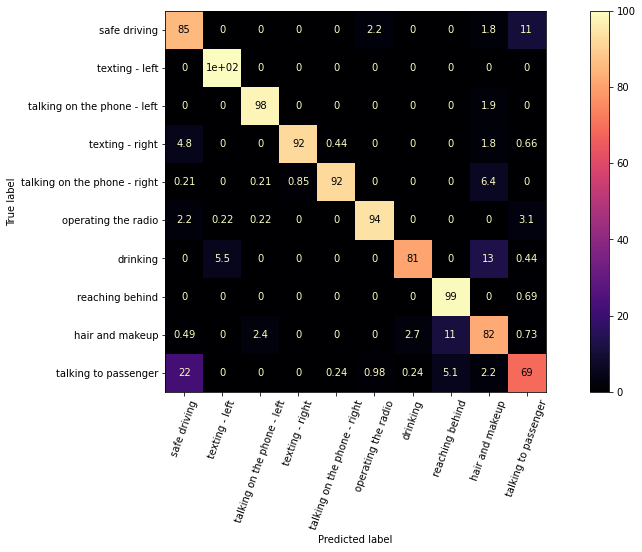

In [41]:
disp=ConfusionMatrixDisplay(c_m,display_labels=list(class_name.values()))
fig, ax = plt.subplots(figsize=(16,7))
disp.plot(ax=ax,
          xticks_rotation=70,
          cmap="magma")
plt.show()

<h1> Accuracy, Precision, Recall and F1 score </h1>

In [42]:
accuracy=accuracy_score(y_true, y_pred)
precision=precision_score(y_true, y_pred, average='weighted')
recall=recall_score(y_true, y_pred, average='weighted')
f1=f1_score(y_true, y_pred, average='weighted')

In [43]:
print("accuracy of the model: ",round(accuracy,4)*100,"%")
print("precision of the model: ",round(precision,4))
print("recall of the model: ",round(recall,4))
print("f1 of the model: ",round(f1,4))

accuracy of the model:  89.64 %
precision of the model:  0.9018
recall of the model:  0.8964
f1 of the model:  0.8968


<h1> Results on Random Unlabelled Test Images </h1> 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.17it/s]


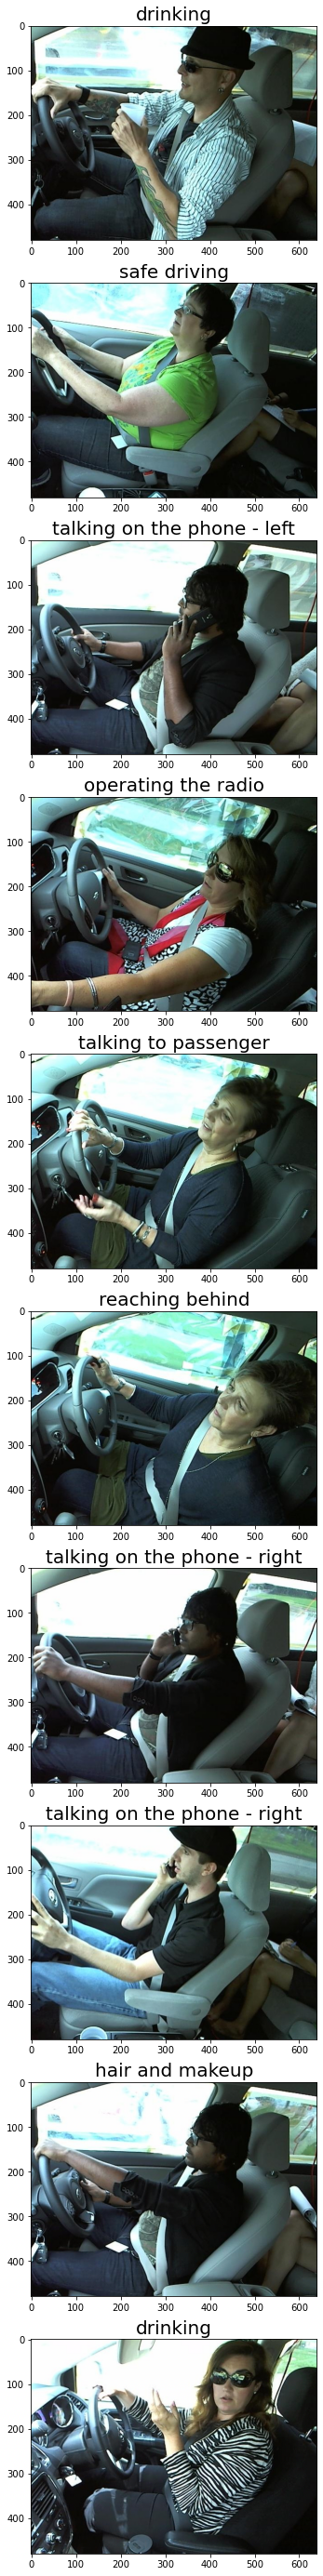

In [44]:
test_image_names=random.choices(os.listdir(test_image_path),k=10) #taking 10 random unlabelled test images
fig, ax = plt.subplots(10, 1, figsize = (50,50))

for i in tqdm(range(len(test_image_names))):
    image_name=test_image_names[i]
    image=cv2.imread(os.path.join(test_image_path,image_name)) #reading image array
    preprocessed_image1=cv2.resize(image, dsize=(224, 224)) #mobilenet,resnet,vgg16
    preprocessed_image2=cv2.resize(image, dsize=(299, 299)) #xception
    
    pred1=mobile_net.predict(np.array([preprocessed_image1])) #mobilenet
    pred2=res_net.predict(np.array([preprocessed_image1])) #resnet
    pred3=vgg16.predict(np.array([preprocessed_image1])) #vgg16
    pred4=xception.predict(np.array([preprocessed_image2])) #xception
    
    sum_pred=pred1+pred2+pred3+pred4 #summing the probabilities
    class_pred=np.argmax(sum_pred)
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(class_name[class_pred],fontsize=20)
    